In [1]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaModel, RobertaTokenizer, RobertaConfig
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv("/kaggle/input/final-train-data/training_data.csv")
# df = pd.read_csv("/kaggle/input/test-dataset/SarcasmHeadlinesDataset_test.csv")

In [4]:
df.head(5)

,ID,article_link,text,label
0,4724,https://www.huffingtonpost.com/entry/trump-rea...,"how trump really feels about queer people, exp...",0
1,26559,https://www.huffingtonpost.com/entry/egyptian-...,egyptian death sentence for soccer fans puts p...,0
2,24613,https://www.theonion.com/stripper-failing-scho...,stripper failing school she's working self thr...,1
3,9048,https://www.huffingtonpost.com/entry/ken-paxto...,texas attorney general ken paxton indicted,0
4,69,https://www.huffingtonpost.com/entry/debbie-di...,congresswoman fights for gun control because s...,0


In [5]:
df =df[(df['label']==0) | (df['label']==1)]
df['label'] = df['label'].astype(int)

In [6]:
df['label'] = df[df.columns[3]].values.tolist()
new_df = df[['text', 'label']].copy()
new_df.head()

,text,label
0,"how trump really feels about queer people, exp...",0
1,egyptian death sentence for soccer fans puts p...,0
2,stripper failing school she's working self thr...,1
3,texas attorney general ken paxton indicted,0
4,congresswoman fights for gun control because s...,0


In [7]:
new_df.shape

(22895, 2)

In [8]:
train_df, valid_df = train_test_split(new_df, test_size=0.3, random_state=42)

In [9]:
train_df.shape

(16026, 2)

In [10]:
valid_df.shape

(6869, 2)

In [11]:
# train_dataset, valid_dataset = train_test_split(df, test_size=0.3, random_state=42)

In [12]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [13]:
# Training

In [14]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['text']
        self.targets = self.data["label"]
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
#         token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
#             'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [15]:
train_size = 1
train_dataset=train_df.sample(frac=train_size,random_state=200)
train_dataset = train_dataset.reset_index(drop=True)
print("Train Dataset: {}".format(train_dataset.shape))
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)

Train Dataset: (16026, 2)


In [16]:
valid_size = 1
valid_dataset=valid_df.sample(frac=train_size,random_state=200)
valid_dataset = valid_dataset.reset_index(drop=True)
print("Valid Dataset: {}".format(valid_dataset.shape))
valid_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

Valid Dataset: (6869, 2)


In [17]:
# training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
# valid_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

In [18]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
train_params['drop_last'] = True
valid_params['drop_last'] = True

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **valid_params)

In [19]:
class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask):
        # RoBERTa doesn't use token type ids so we don't pass that
        output = self.l1(ids, attention_mask=mask)
        # In transformers>=3.0, outputs are returned as tuples with the first element being last hidden state
        output_1 = output.last_hidden_state[:, 0]  # we take the output from the first token (CLS token)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [20]:
model = RoBERTaClass()
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [21]:
model.load_state_dict(torch.load("/kaggle/input/roberta-model/roberta_model.pth"))

<All keys matched successfully>

In [ ]:
def validation_parameters(targets, outputs):
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    precission = metrics.precision_score(targets, outputs)
    recall = metrics.recall_score(targets, outputs)
    f1_score = metrics.f1_score(targets, outputs)
    classification_report = metrics.classification_report(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs)
    f1_score_macro = metrics.f1_score(targets, outputs)
    print(accuracy)
    print(precission)
    print(recall)
    print(f1_score)
    print(classification_report)

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [ ]:
num_train_batch = len(training_loader)
num_valid_batch = len(valid_loader)
print(num_train_batch,num_valid_batch)

In [ ]:
def validation_training():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    loss = 0
    curr_loss = 0
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
#             token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float).view(VALID_BATCH_SIZE, 1)
            outputs = model(ids, mask)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            loss = loss_fn(outputs, targets)
            curr_loss+=loss.data.item()
#             break
#         precission, recall, f1_score, accuracy, classification_report = validation_parameters(fin_targets,fin_outputs)
    return curr_loss/(len(valid_loader)*VALID_BATCH_SIZE)

In [ ]:
# Initialize your lists and other variables
train_loss = []
valid_loss = []
EPOCHS = 15
best_val_loss = float('inf')  # Initialize with a very large value
best_model_path = 'best_roberta_model.pth'

# Define the exponential scheduler
scheduler = ExponentialLR(optimizer, gamma=0.5)  # You can adjust the gamma value as needed

# Training loop
for epoch in range(EPOCHS):
    model.train()
    curr_loss = 0
    for batch_num, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float).reshape(TRAIN_BATCH_SIZE, -1)
        
        outputs = model(ids, mask)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        curr_loss += loss.data.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         break  # For demonstration, remove this break when training

    # Calculate and append train loss
    train_loss.append(curr_loss / (len(training_loader) * TRAIN_BATCH_SIZE))
    
    # Calculate validation loss
    val_loss = validation_training()
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    print("Updated learning rate:", optimizer.param_groups[0]['lr'])

    # Save the model if the validation loss improves
    if val_loss < best_val_loss:
        print("Validation loss improved from {:.4f} to {:.4f}. Saving model...".format(best_val_loss, val_loss))
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
    
    # Print and append validation loss
    print('Valid loss: {:.4f}'.format(val_loss))
    valid_loss.append(val_loss)
    print("Epoch: {} Train Loss: {:.4f} Valid Loss: {:.4f}".format(epoch + 1, train_loss[-1], valid_loss[-1]))


In [ ]:
import csv


# Define the file name
file_name = "loss_data.csv"

# Write the data to the CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['train_loss', 'valid_loss'])  # Write header
    for train, valid in zip(train_loss, valid_loss):
        writer.writerow([train, valid])
        
print("CSV file created successfully.")


In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(valid_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# model_path = "/kaggle/working/roberta_model.pth"
# torch.save(model.state_dict(), model_path)

In [36]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
#             token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            if i%100 == 0:
                print(i)
    return fin_outputs, fin_targets

In [37]:
outputs, targets = validation()

2it [00:00,  9.04it/s]

0


102it [00:10,  9.46it/s]

100


202it [00:21,  9.43it/s]

200


302it [00:31,  9.47it/s]

300


402it [00:42,  9.40it/s]

400


429it [00:45,  9.43it/s]


In [38]:
# outputs = np.array(outputs) >= 0.5
# accuracy = metrics.accuracy_score(targets, outputs)
# f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
# f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
# classication_metrics = metrics.classification_report(targets, outputs)
# conf_met = metrics.confusion_matrix(targets, outputs)
# print(f"Accuracy Score = {accuracy}")
# print("Classication metrics:")
# print(classication_metrics)
# print("Confusion metrics:")
# print(conf_met)
# print(f"F1 Score (Micro) = {f1_score_micro}")
# print(f"F1 Score (Macro) = {f1_score_macro}")

Confusion Matrix =
[[3517   53]
 [ 122 3172]]
Accuracy Score = 0.974504662004662
Classification metrics:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3570
         1.0       0.98      0.96      0.97      3294

    accuracy                           0.97      6864
   macro avg       0.98      0.97      0.97      6864
weighted avg       0.97      0.97      0.97      6864

F1 Score (Micro) = 0.974504662004662
F1 Score (Macro) = 0.9744400901950743
AUROC Score = 0.9956532886378595


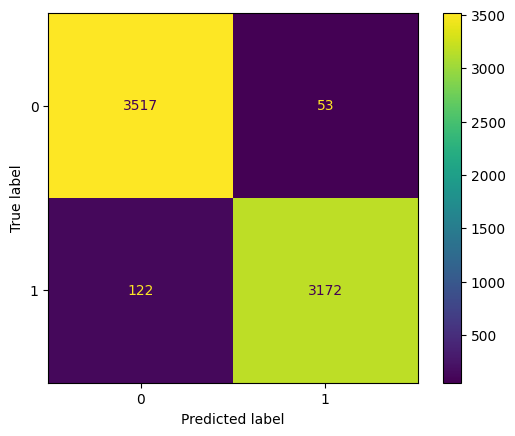

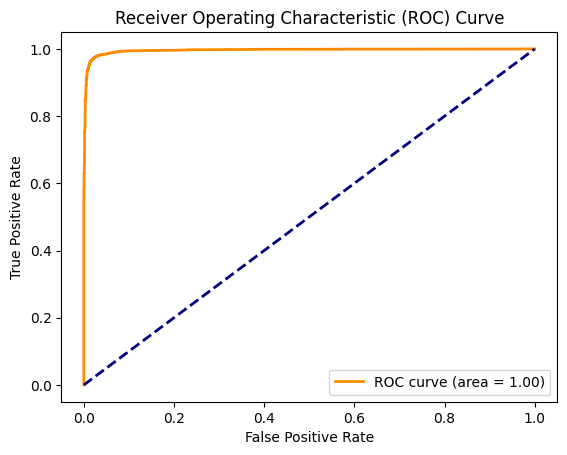

In [39]:
outputs_binary = np.array(outputs) >= 0.5

# Calculate accuracy
accuracy = metrics.accuracy_score(targets, outputs_binary)

# Calculate F1 score (micro)
f1_score_micro = metrics.f1_score(targets, outputs_binary, average='micro')

# Calculate F1 score (macro)
f1_score_macro = metrics.f1_score(targets, outputs_binary, average='macro')

# Calculate classification report
classification_report = metrics.classification_report(targets, outputs_binary)

# Calculate confusion matrix
cm = metrics.confusion_matrix(targets, outputs_binary)
print("Confusion Matrix =")
print(cm)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()
# plt.show()
plt.savefig('confusion_matrix.png')

# Print accuracy score
print(f"Accuracy Score = {accuracy}")

# Print classification metrics
print("Classification metrics:")
print(classification_report)



# Print F1 scores
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(targets, outputs)

# Calculate AUROC score
auroc_score = metrics.roc_auc_score(targets, outputs)

# Print AUROC score
print(f"AUROC Score = {auroc_score}")

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()